In [22]:
import torch
import random
from tqdm import tqdm
from torch.utils.data import Dataset
import math
import pandas as pd #only used for viewing the datset
import numpy as np
import os
from sklearn.utils import shuffle
import time

import tensorflow as tf
from tensorflow import keras

from matplotlib import cm
from matplotlib import pyplot as plt
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE" ## since my kernel always breaks down suddenly , I have to add this line

import warnings
warnings.filterwarnings('ignore')


In [23]:
class mandelbrotDataSet: 

    def __init__(self,  x_center=0.2,y_center=0.5,semi_width=0.2,size = 600, max_depth = 50):
        ## N = size * size elements, default is a N= 600 * 600 =360000 elements set.
        self.size = size      
        self.max_depth = max_depth
        self.outputs = []
        self.x_from,self.x_to,self.y_from,self.y_to = x_center-semi_width,x_center+semi_width,\
                          y_center-semi_width,y_center+semi_width
        
        self.y,self.x = np.ogrid[self.y_from:self.y_to:self.size*1j,self.x_from:self.x_to:self.size*1j]
        
        self.c = self.x + self.y*1j
        print("c.shape:",self.c.shape,"x.shape:",self.x.shape,"y.shape:",self.y.shape)
        
        self.outputs=np.frompyfunc(self.f,1,1)(self.c).astype(np.float)       
    
    def f(self, a):
        z = 0
        ## The maximum escape time is max_depth-1 
        for n in range(1, self.max_depth):
            z = z ** 2 + a
            if abs(z) > 2:
                return n ## the iterate times is used to map colors
        return n 

    def get_X_and_Y(self):
        
        xc=np.squeeze(self.c.real.reshape(1,-1))## get real part and reshape to a vector
        yc=np.squeeze(self.c.imag.reshape(1,-1))## get imaginary part and reshape to a vector
        color=np.squeeze(self.outputs.reshape(1,-1))
        label=(color==self.max_depth-1)
        return np.array(list(zip(xc,yc))),label,color

            
    def view(self):
        dataframe = pd.DataFrame(data = [], columns = ["x","y", "Belongs?","color"])
        xc=np.squeeze(self.c.real.reshape(1,-1))## get real part and reshape to a vector
        yc=np.squeeze(self.c.imag.reshape(1,-1))## get imaginary part and reshape to a vector
        dataframe.x=xc
        dataframe.y=yc
        color=np.squeeze(self.outputs.reshape(1,-1))# get outputs and reshape to a vector
        dataframe.color=color
        dataframe["Belongs?"]= (color==self.max_depth-1)

        return dataframe       


In [24]:
class Para: ## A Para class with only a name is used to store global parameters
    pass

para = Para()
## You can change the color of the image by changing the idxColorMap
para.idxColorMap = 1
## the total color type is in cmaps list
para.cmaps = [ 'ocean', 'gist_earth', 'terrain', 'gist_stern',
         'gnuplot', 'gnuplot2', 'CMRmap', 'cubehelix', 'brg','gist_rainbow',
         'rainbow', 'jet', 'nipy_spectral', 'gist_ncar']


def drawImage(ds,cmaps):
    para.fig = plt.figure(figsize=(12,6),dpi=100)
    para.ax0 = plt.subplot(121)
    para.ax0.set_axis_off()## Hide the coordinates of the subgraph
    c = cm.get_cmap(cmaps[para.idxColorMap%len(cmaps)])
    ## The cmap function inside imshow() corresponds to a color map object, which is responsible for converting the value of the 
    ## element (i.e., the escape time of the complex c) to the corresponding color.
    para.ax0.imshow(ds,cmap=c)

In [26]:
mandelbrot = mandelbrotDataSet(size=600) 
new_x, new_Y, new_color = mandelbrot.get_X_and_Y() 
shuffled_X, shuffled_Color = shuffle(new_x, new_color, random_state = 42)
new_X_train, new_X_test = shuffled_X[:math.ceil(shuffled_X.shape[0] * 0.5)], shuffled_X[math.ceil(shuffled_X.shape[0] * 0.5):]
new_Color_train, new_Color_test = shuffled_Color[:math.ceil(shuffled_Color.shape[0] * 0.5)], shuffled_Color[math.ceil(shuffled_Color.shape[0] * 0.5):]

c.shape: (600, 600) x.shape: (1, 600) y.shape: (600, 1)


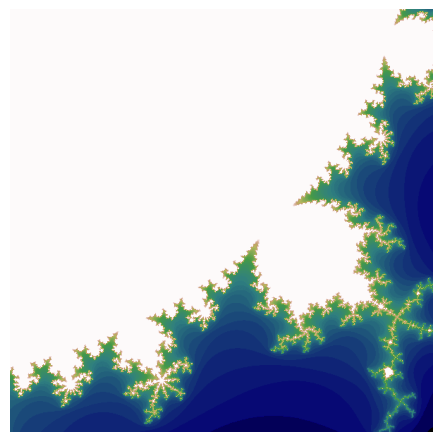

In [10]:
drawImage(mandelbrot.outputs,para.cmaps)

In [6]:
def view_model_on_image(model):
    dataset = mandelbrotDataSet() 
    X,Label,Color = dataset.get_X_and_Y()
    predictions = model.predict(X)
    predictions_as_classes = np.argmax(predictions, axis = 1)
    drawImage(predictions_as_classes.reshape(600,-1),para.cmaps)

def view_history(history):
    pd.DataFrame(history.history).plot(figsize = (8, 8))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()

In [7]:
def get_model(num_hidden_layers, neurons_per_hidden_layer, activation):
    model = keras.models.Sequential() 
    model.add(keras.layers.Flatten(input_shape  = [2, 1]))  
    for layer in range(num_hidden_layers):       
        model.add(keras.layers.Dense(neurons_per_hidden_layer, activation = activation)) 
    model.add(keras.layers.Dense(50, activation = "softmax"))     
    return model

In [8]:
def train_models(hidden_layer_options, options_for_number_of_neruons, activation_options, optimiser_options, learning_rates, num_epochs, X_train, Y_train, X_validation, Y_validation):
    num_options = len(hidden_layer_options) * len(options_for_number_of_neruons) * len(activation_options) * len(optimiser_options) * len(learning_rates) * len(num_epochs)
    print("Creating and Trainining {} Models:".format(num_options))
    trained_models = []    
    i = 1
    for hidden_layers in hidden_layer_options:
        for num_neruons in options_for_number_of_neruons:
            for activation in activation_options: 
                for optimiser_to_use in optimiser_options: 
                    for lr in learning_rates:
                        for epochs in num_epochs: 
                            start_time = time.time()
                            if optimiser_to_use == "SGD": 
                                optimiser = tf.keras.optimizers.SGD(learning_rate = lr)
                            
                            elif optimiser_to_use == "ADAM": 
                                optimiser =  tf.keras.optimizers.Adam(learning_rate = lr)
                            
                            elif optimiser_to_use == "RMSprop": 
                                optimiser = tf.keras.optimizers.RMSprop(learning_rate=lr,rho=0.9,momentum=0.0,epsilon=1e-07, centered=False,name='RMSprop')
                            
                            model = get_model(hidden_layers, num_neruons, activation)
                            model.compile(loss = "sparse_categorical_crossentropy", optimizer = optimiser, metrics = ["accuracy"])
                            history = model.fit(X_train, Y_train, epochs = epochs, validation_data = (X_validation, Y_validation), verbose = 0)

                            name = "#Hidden layers = {}, #Neurons per hidden layer = {}, Activation = {}, Optimiser = {}, Learning Rate = {}, #Epochs = {},".format(hidden_layers, num_neruons, activation, optimiser_to_use, lr, epochs)
                            tup = (name, history, model)
                            trained_models.append(tup)
                            end_time = time.time()
                            print("{} / {} complete".format(i, num_options))
                            print("elapsed_time = {:2f}".format(end_time - start_time))
                            print()
                            i += 1
    return trained_models                       


### Finding best Number of Hidden Layers

In [13]:
hidden_layer_options = [1, 2, 3, 4, 5] #Checking this paramater. 

options_for_number_of_neurons = [50] 
activation_options = ["relu"]
optimiser_options = ["ADAM"]
num_epochs = [30]
learning_rates = [0.01]

In [14]:
trained_models = train_models(hidden_layer_options, options_for_number_of_neurons, activation_options, optimiser_options, learning_rates, num_epochs, new_X_train, new_Color_train, new_X_test, new_Color_test)

Creating and Trainining 5 Models:
1 / 5 complete
elapsed_time = 130.620156

2 / 5 complete
elapsed_time = 135.534970

3 / 5 complete
elapsed_time = 139.042019

4 / 5 complete
elapsed_time = 144.465890

5 / 5 complete
elapsed_time = 147.242630



In [15]:
trained_model_1 = trained_models[0]
trained_model_2 = trained_models[1]
trained_model_3 = trained_models[2]
trained_model_4 = trained_models[3]
trained_model_5 = trained_models[4]

#Hidden layers = 1, #Neurons per hidden layer = 50, Activation = relu, Optimiser = ADAM, Learning Rate = 0.01, #Epochs = 30,


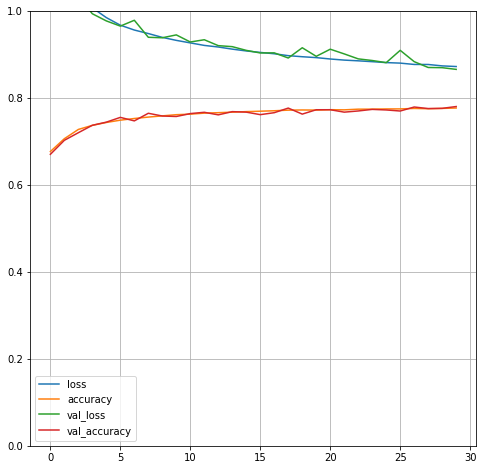

c.shape: (600, 600) x.shape: (1, 600) y.shape: (600, 1)
11250/11250 [==============================] - 4s 385us/step


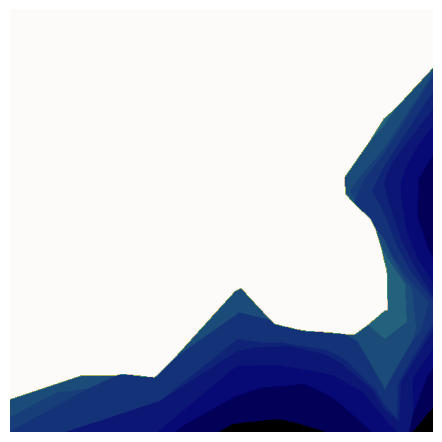

In [17]:
print(trained_model_1[0])
view_history(trained_model_1[1])
view_model_on_image(trained_model_1[2])

#Hidden layers = 2, #Neurons per hidden layer = 50, Activation = relu, Optimiser = ADAM, Learning Rate = 0.01, #Epochs = 30,


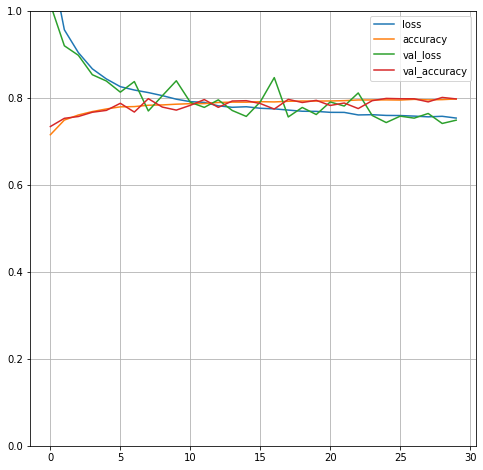

c.shape: (600, 600) x.shape: (1, 600) y.shape: (600, 1)
11250/11250 [==============================] - 4s 384us/step


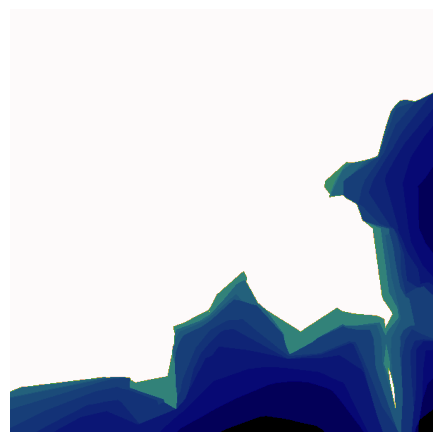

In [18]:
print(trained_model_2[0])
view_history(trained_model_2[1])
view_model_on_image(trained_model_2[2])

#Hidden layers = 3, #Neurons per hidden layer = 50, Activation = relu, Optimiser = ADAM, Learning Rate = 0.01, #Epochs = 30,


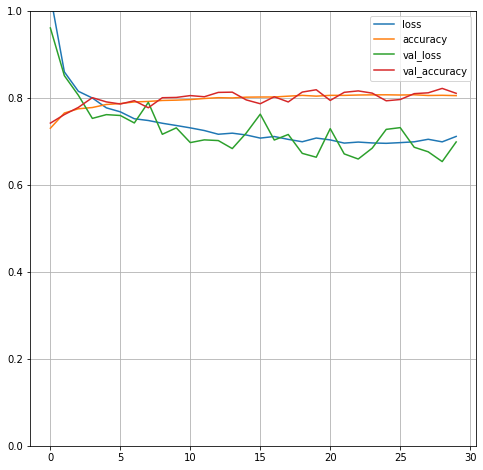

c.shape: (600, 600) x.shape: (1, 600) y.shape: (600, 1)
11250/11250 [==============================] - 4s 385us/step


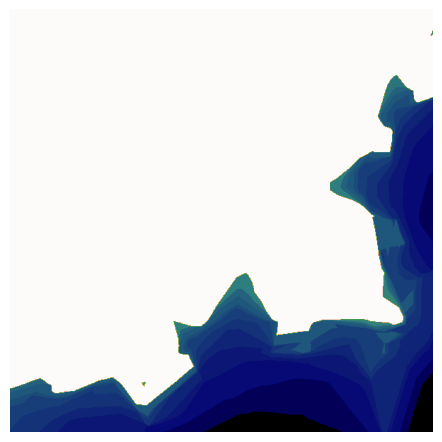

In [19]:
print(trained_model_3[0])
view_history(trained_model_3[1])
view_model_on_image(trained_model_3[2])

#Hidden layers = 4, #Neurons per hidden layer = 50, Activation = relu, Optimiser = ADAM, Learning Rate = 0.01, #Epochs = 30,


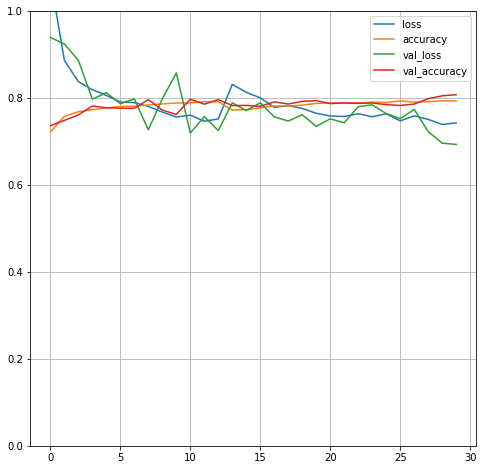

c.shape: (600, 600) x.shape: (1, 600) y.shape: (600, 1)
11250/11250 [==============================] - 4s 382us/step


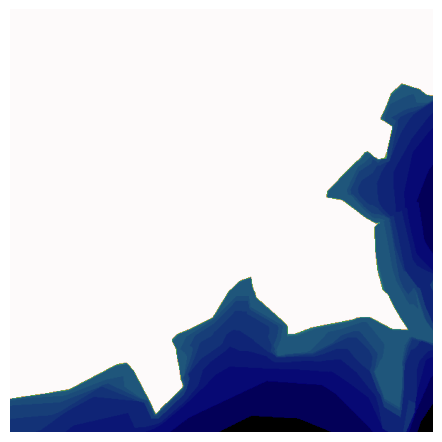

In [20]:
print(trained_model_4[0])
view_history(trained_model_4[1])
view_model_on_image(trained_model_4[2])

#Hidden layers = 5, #Neurons per hidden layer = 50, Activation = relu, Optimiser = ADAM, Learning Rate = 0.01, #Epochs = 30,


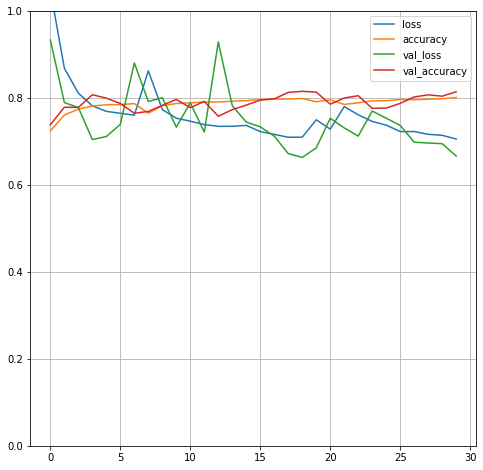

c.shape: (600, 600) x.shape: (1, 600) y.shape: (600, 1)
11250/11250 [==============================] - 4s 380us/step


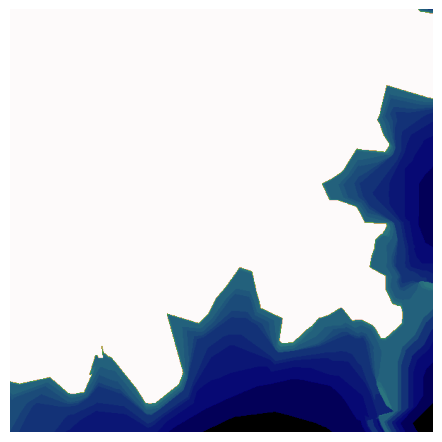

In [21]:
print(trained_model_5[0]) # We pick this model!
view_history(trained_model_5[1])
view_model_on_image(trained_model_5[2])

Best number of hidden layers is 5

### Finding best Number of Neurons insinde of each Hidden Layers

In [22]:
hidden_layer_options = [5] 

options_for_number_of_neurons = [50, 100, 200, 300, 500] # Checking this paramter

activation_options = ["relu"]
optimiser_options = ["ADAM"]
num_epochs = [30]
learning_rates = [0.01]

In [23]:
trained_models = train_models(hidden_layer_options, options_for_number_of_neurons, activation_options, optimiser_options, learning_rates, num_epochs, new_X_train, new_Color_train, new_X_test, new_Color_test)

Creating and Trainining 5 Models:
1 / 5 complete
elapsed_time = 149.283320

2 / 5 complete
elapsed_time = 161.858986

3 / 5 complete
elapsed_time = 233.338073

4 / 5 complete
elapsed_time = 339.801437

5 / 5 complete
elapsed_time = 610.571974



In [24]:
trained_model_1 = trained_models[0]
trained_model_2 = trained_models[1]
trained_model_3 = trained_models[2]
trained_model_4 = trained_models[3]
trained_model_5 = trained_models[4]

#Hidden layers = 5, #Neurons per hidden layer = 50, Activation = relu, Optimiser = ADAM, Learning Rate = 0.01, #Epochs = 30,


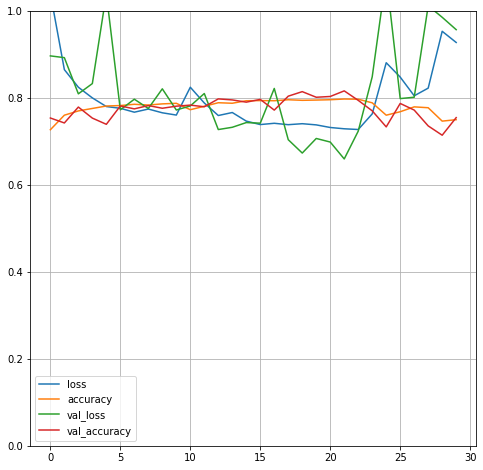

c.shape: (600, 600) x.shape: (1, 600) y.shape: (600, 1)
11250/11250 [==============================] - 4s 372us/step


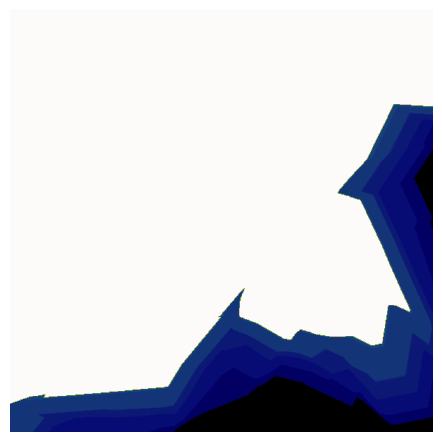

In [25]:
print(trained_model_1[0])
view_history(trained_model_1[1])
view_model_on_image(trained_model_1[2])

#Hidden layers = 5, #Neurons per hidden layer = 100, Activation = relu, Optimiser = ADAM, Learning Rate = 0.01, #Epochs = 30,


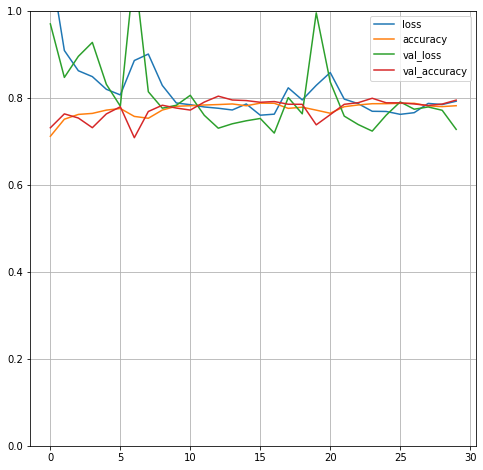

c.shape: (600, 600) x.shape: (1, 600) y.shape: (600, 1)
11250/11250 [==============================] - 4s 389us/step


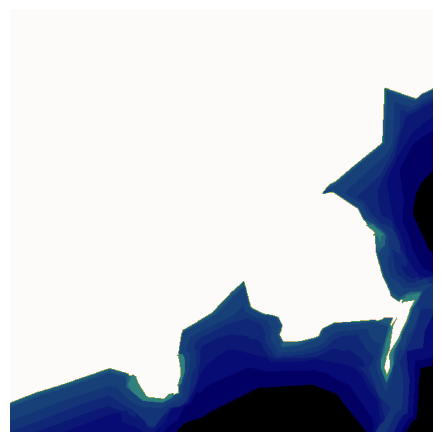

In [26]:
print(trained_model_2[0])
view_history(trained_model_2[1])
view_model_on_image(trained_model_2[2])

#Hidden layers = 5, #Neurons per hidden layer = 200, Activation = relu, Optimiser = ADAM, Learning Rate = 0.01, #Epochs = 30,


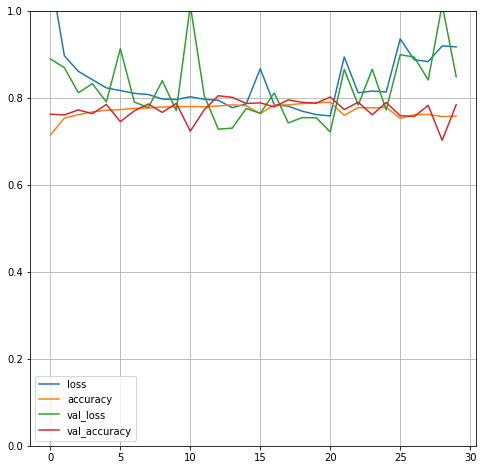

c.shape: (600, 600) x.shape: (1, 600) y.shape: (600, 1)
11250/11250 [==============================] - 6s 531us/step


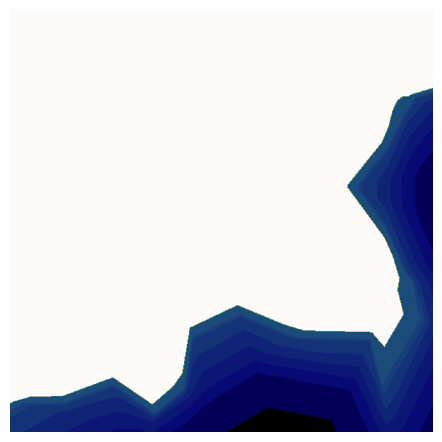

In [27]:
print(trained_model_3[0])
view_history(trained_model_3[1])
view_model_on_image(trained_model_3[2])

#Hidden layers = 5, #Neurons per hidden layer = 300, Activation = relu, Optimiser = ADAM, Learning Rate = 0.01, #Epochs = 30,


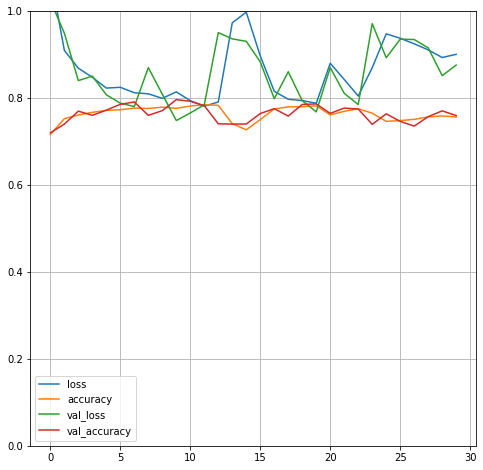

c.shape: (600, 600) x.shape: (1, 600) y.shape: (600, 1)
11250/11250 [==============================] - 9s 841us/step


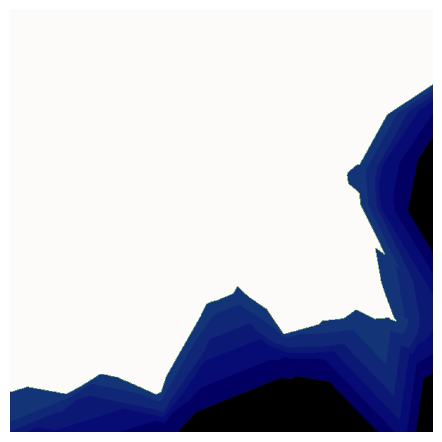

In [28]:
print(trained_model_4[0])
view_history(trained_model_4[1])
view_model_on_image(trained_model_4[2])

#Hidden layers = 5, #Neurons per hidden layer = 500, Activation = relu, Optimiser = ADAM, Learning Rate = 0.01, #Epochs = 30,


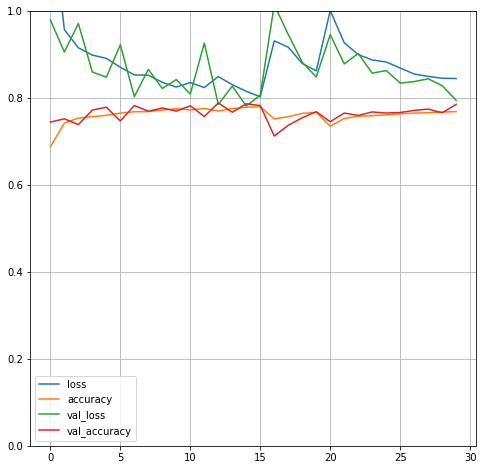

c.shape: (600, 600) x.shape: (1, 600) y.shape: (600, 1)
11250/11250 [==============================] - 18s 2ms/step


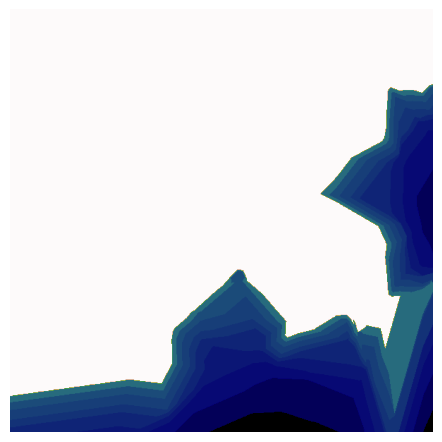

In [29]:
print(trained_model_5[0]) # We pick this model!
view_history(trained_model_5[1])
view_model_on_image(trained_model_5[2])

Best number of neruons in hidden layer is X

### Finding best optimiser and learning rate

In [32]:
hidden_layer_options = [5] 

options_for_number_of_neurons = [500] # Checking this paramter

activation_options = ["relu"]
optimiser_options = ["ADAM", "RMSprop", "SGD"]
num_epochs = [30]
learning_rates = [0.01, 0.001]

In [33]:
trained_models = train_models(hidden_layer_options, options_for_number_of_neurons, activation_options, optimiser_options, learning_rates, num_epochs, new_X_train, new_Color_train, new_X_test, new_Color_test)

Creating and Trainining 6 Models:
1 / 6 complete
elapsed_time = 918.468276

2 / 6 complete
elapsed_time = 966.042117

3 / 6 complete
elapsed_time = 1094.094970

4 / 6 complete
elapsed_time = 1326.100813

5 / 6 complete
elapsed_time = 1380.854526

6 / 6 complete
elapsed_time = 1413.870329



In [34]:
trained_model_1 = trained_models[0]
trained_model_2 = trained_models[1]
trained_model_3 = trained_models[2]
trained_model_4 = trained_models[3]
trained_model_5 = trained_models[4]
trained_model_6 = trained_models[5]

#Hidden layers = 5, #Neurons per hidden layer = 500, Activation = relu, Optimiser = ADAM, Learning Rate = 0.01, #Epochs = 30,


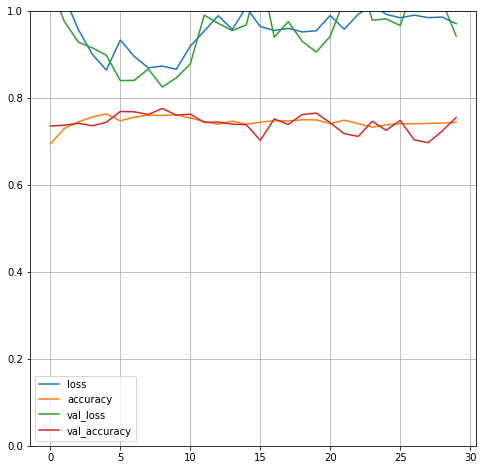

c.shape: (600, 600) x.shape: (1, 600) y.shape: (600, 1)
11250/11250 [==============================] - 28s 3ms/step


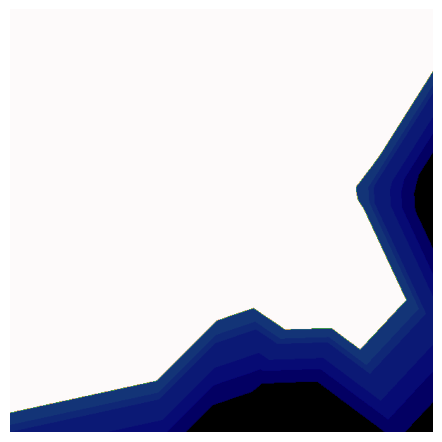

In [35]:
print(trained_model_1[0])
view_history(trained_model_1[1])
view_model_on_image(trained_model_1[2])

#Hidden layers = 5, #Neurons per hidden layer = 500, Activation = relu, Optimiser = ADAM, Learning Rate = 0.001, #Epochs = 30,


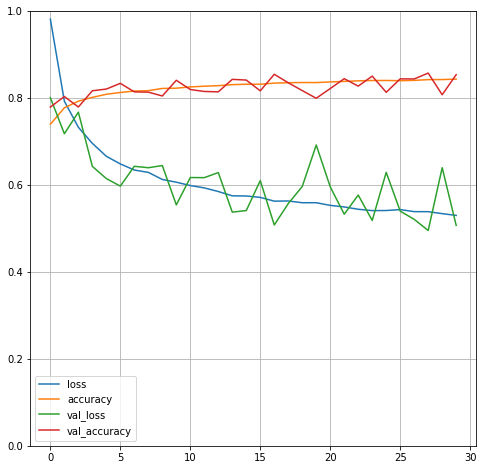

c.shape: (600, 600) x.shape: (1, 600) y.shape: (600, 1)
11250/11250 [==============================] - 26s 2ms/step


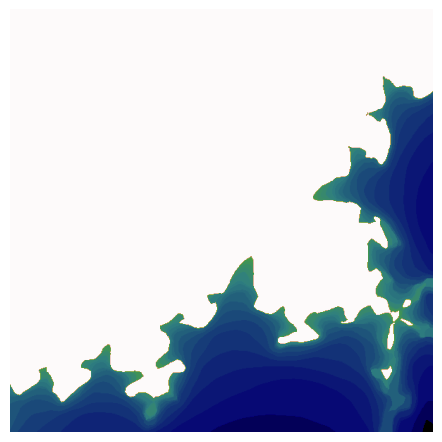

In [36]:
print(trained_model_2[0])
view_history(trained_model_2[1])
view_model_on_image(trained_model_2[2])

#Hidden layers = 5, #Neurons per hidden layer = 500, Activation = relu, Optimiser = RMSprop, Learning Rate = 0.01, #Epochs = 30,


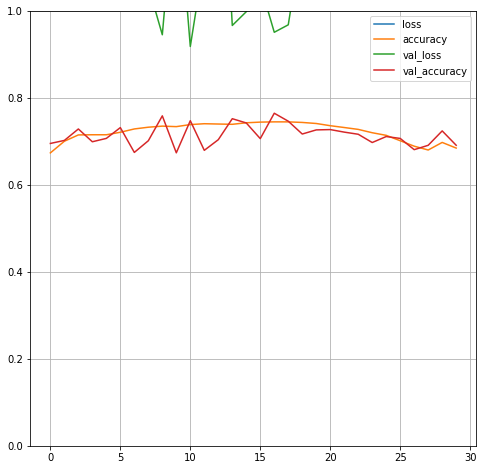

c.shape: (600, 600) x.shape: (1, 600) y.shape: (600, 1)
11250/11250 [==============================] - 26s 2ms/step


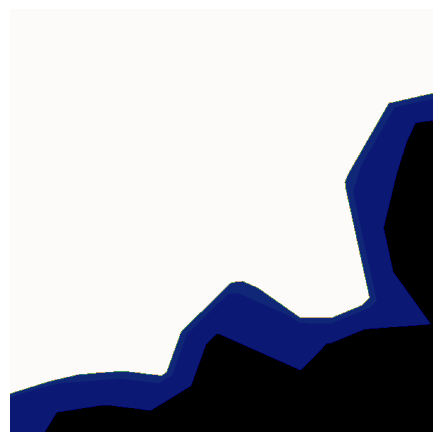

In [37]:
print(trained_model_3[0])
view_history(trained_model_3[1])
view_model_on_image(trained_model_3[2])

#Hidden layers = 5, #Neurons per hidden layer = 500, Activation = relu, Optimiser = RMSprop, Learning Rate = 0.001, #Epochs = 30,


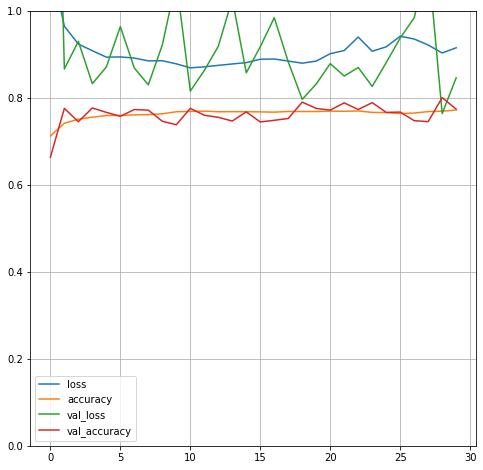

c.shape: (600, 600) x.shape: (1, 600) y.shape: (600, 1)
11250/11250 [==============================] - 26s 2ms/step


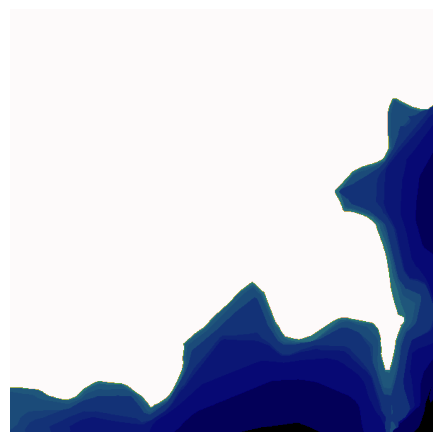

In [38]:
print(trained_model_4[0])
view_history(trained_model_4[1])
view_model_on_image(trained_model_4[2])

#Hidden layers = 5, #Neurons per hidden layer = 500, Activation = relu, Optimiser = SGD, Learning Rate = 0.01, #Epochs = 30,


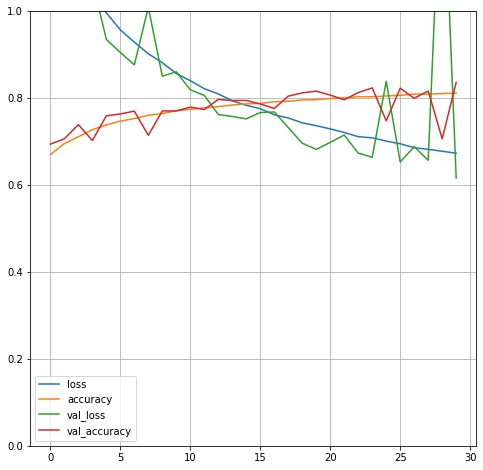

c.shape: (600, 600) x.shape: (1, 600) y.shape: (600, 1)
11250/11250 [==============================] - 26s 2ms/step


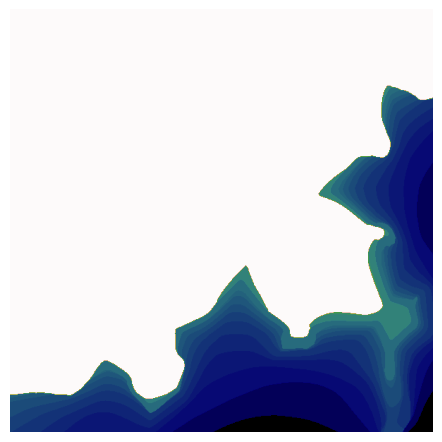

In [39]:
print(trained_model_5[0])
view_history(trained_model_5[1])
view_model_on_image(trained_model_5[2])

#Hidden layers = 5, #Neurons per hidden layer = 500, Activation = relu, Optimiser = SGD, Learning Rate = 0.001, #Epochs = 30,


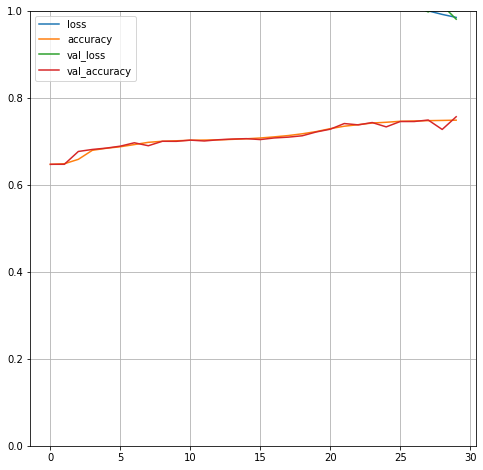

c.shape: (600, 600) x.shape: (1, 600) y.shape: (600, 1)
11250/11250 [==============================] - 27s 2ms/step


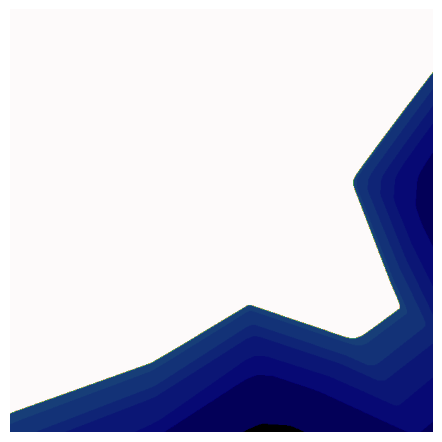

In [40]:
print(trained_model_6[0])
view_history(trained_model_6[1])
view_model_on_image(trained_model_6[2])

ADAM 0.001 IS BEST!

### Changing architecture with adam 0.001

In [11]:
hidden_layer_options = [5, 10, 15, 20] 

options_for_number_of_neurons = [300, 500] # Checking this paramter

activation_options = ["relu"]
optimiser_options = ["ADAM"]
num_epochs = [30]
learning_rates = [0.001]

In [12]:
trained_models = train_models(hidden_layer_options, options_for_number_of_neurons, activation_options, optimiser_options, learning_rates, num_epochs, new_X_train, new_Color_train, new_X_test, new_Color_test)

Creating and Trainining 8 Models:
1 / 8 complete
elapsed_time = 313.907400

2 / 8 complete
elapsed_time = 532.071072

3 / 8 complete
elapsed_time = 567.983970

4 / 8 complete
elapsed_time = 1094.290477

5 / 8 complete
elapsed_time = 890.308160

6 / 8 complete
elapsed_time = 1774.914465

7 / 8 complete
elapsed_time = 1169.981102

8 / 8 complete
elapsed_time = 2533.951376



In [13]:
trained_model_1 = trained_models[0]
trained_model_2 = trained_models[1]
trained_model_3 = trained_models[2]
trained_model_4 = trained_models[3]
trained_model_5 = trained_models[4]
trained_model_6 = trained_models[5]
trained_model_7 = trained_models[6]
trained_model_8 = trained_models[7]

#Hidden layers = 5, #Neurons per hidden layer = 300, Activation = relu, Optimiser = ADAM, Learning Rate = 0.001, #Epochs = 30,


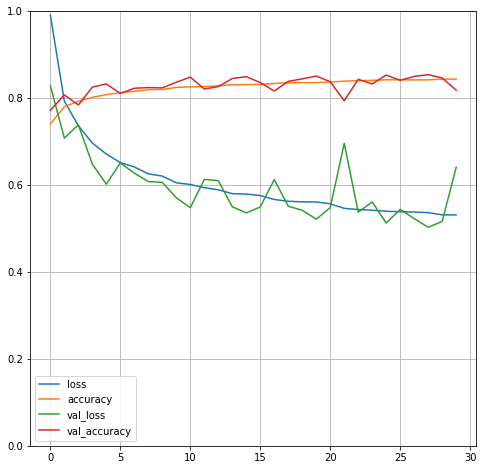

c.shape: (600, 600) x.shape: (1, 600) y.shape: (600, 1)
11250/11250 [==============================] - 8s 671us/step


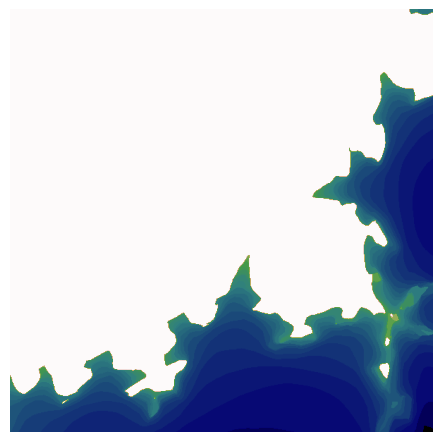

In [14]:
print(trained_model_1[0])
view_history(trained_model_1[1])
view_model_on_image(trained_model_1[2])

#Hidden layers = 5, #Neurons per hidden layer = 500, Activation = relu, Optimiser = ADAM, Learning Rate = 0.001, #Epochs = 30,


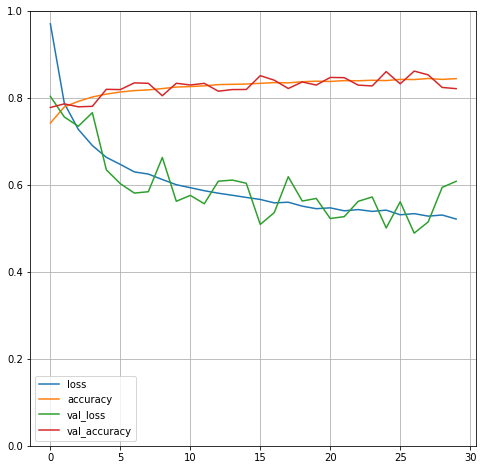

c.shape: (600, 600) x.shape: (1, 600) y.shape: (600, 1)
11250/11250 [==============================] - 14s 1ms/step


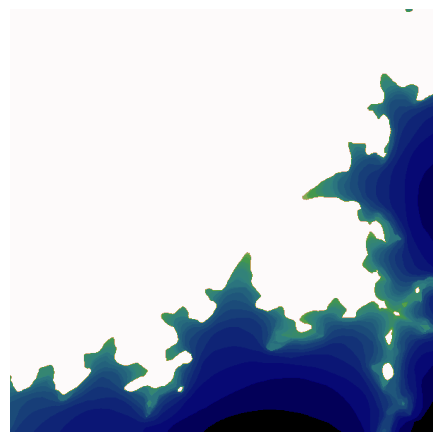

In [15]:
print(trained_model_2[0])
view_history(trained_model_2[1])
view_model_on_image(trained_model_2[2])

#Hidden layers = 10, #Neurons per hidden layer = 300, Activation = relu, Optimiser = ADAM, Learning Rate = 0.001, #Epochs = 30,


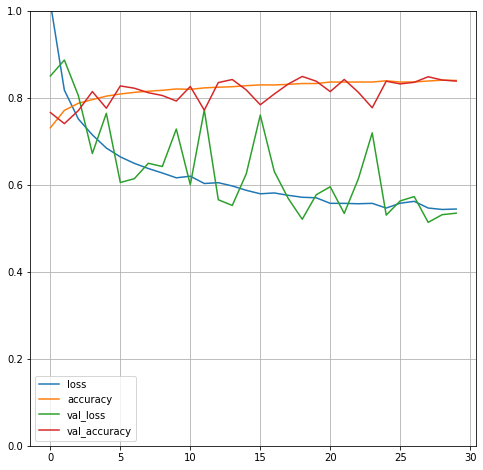

c.shape: (600, 600) x.shape: (1, 600) y.shape: (600, 1)
11250/11250 [==============================] - 12s 1ms/step


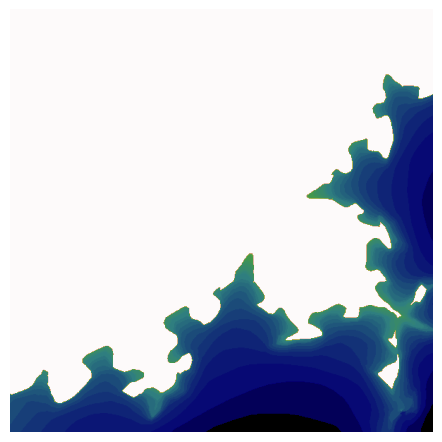

In [16]:
print(trained_model_3[0])
view_history(trained_model_3[1])
view_model_on_image(trained_model_3[2])

#Hidden layers = 10, #Neurons per hidden layer = 500, Activation = relu, Optimiser = ADAM, Learning Rate = 0.001, #Epochs = 30,


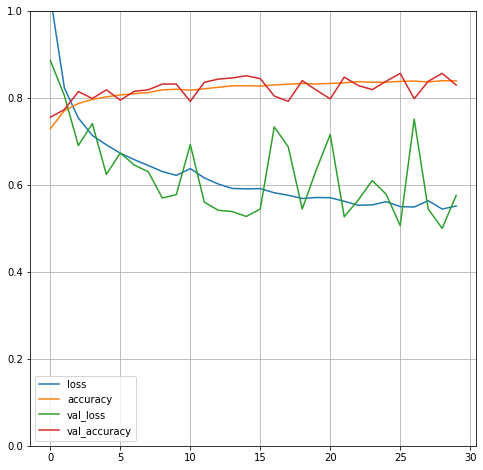

c.shape: (600, 600) x.shape: (1, 600) y.shape: (600, 1)
11250/11250 [==============================] - 25s 2ms/step


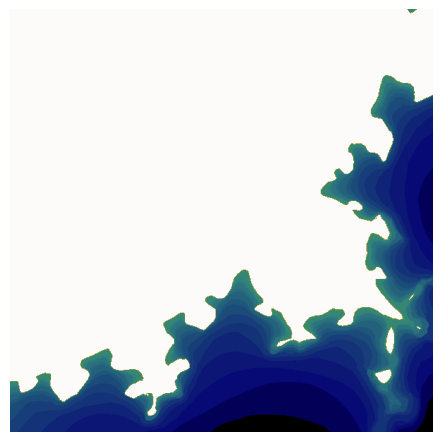

In [17]:
print(trained_model_4[0])
view_history(trained_model_4[1])
view_model_on_image(trained_model_4[2])

#Hidden layers = 15, #Neurons per hidden layer = 300, Activation = relu, Optimiser = ADAM, Learning Rate = 0.001, #Epochs = 30,


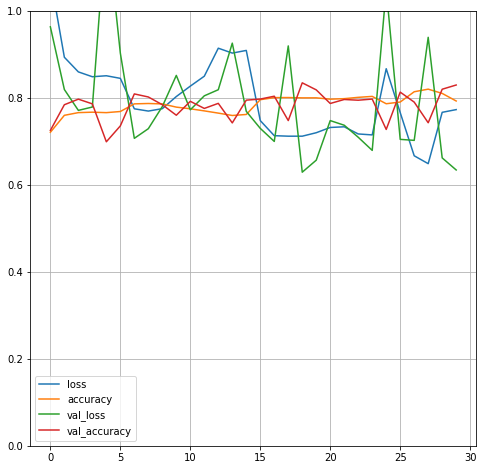

c.shape: (600, 600) x.shape: (1, 600) y.shape: (600, 1)
11250/11250 [==============================] - 16s 1ms/step


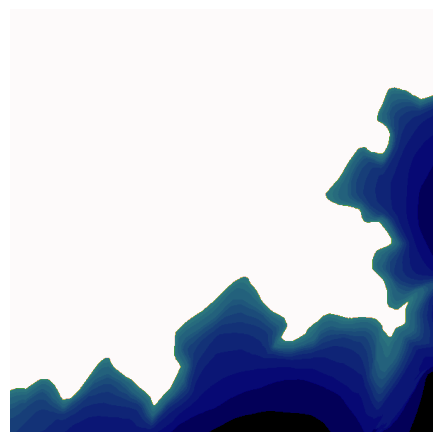

In [18]:
print(trained_model_5[0])
view_history(trained_model_5[1])
view_model_on_image(trained_model_5[2])

#Hidden layers = 15, #Neurons per hidden layer = 500, Activation = relu, Optimiser = ADAM, Learning Rate = 0.001, #Epochs = 30,


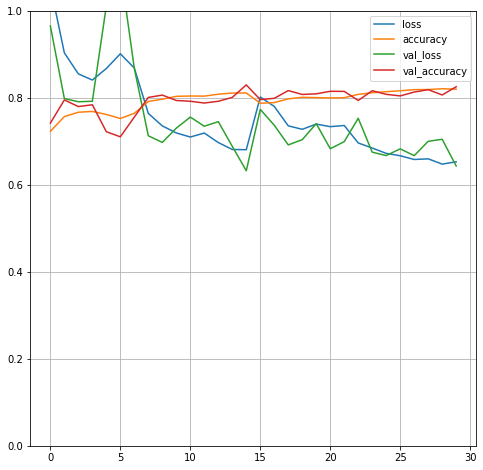

c.shape: (600, 600) x.shape: (1, 600) y.shape: (600, 1)
11250/11250 [==============================] - 38s 3ms/step


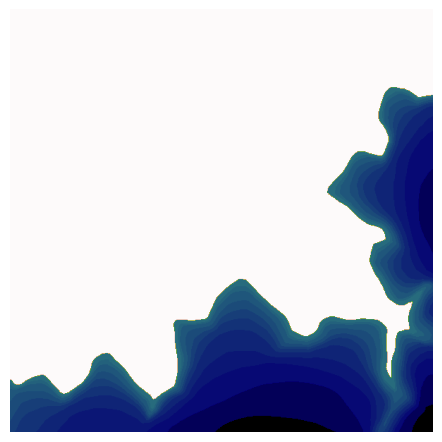

In [19]:
print(trained_model_6[0])
view_history(trained_model_6[1])
view_model_on_image(trained_model_6[2])

#Hidden layers = 20, #Neurons per hidden layer = 300, Activation = relu, Optimiser = ADAM, Learning Rate = 0.001, #Epochs = 30,


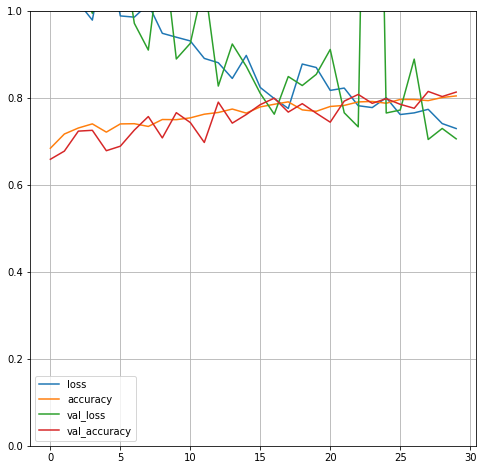

c.shape: (600, 600) x.shape: (1, 600) y.shape: (600, 1)
11250/11250 [==============================] - 20s 2ms/step


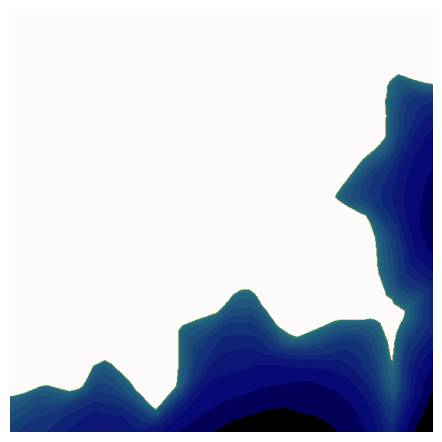

In [20]:
print(trained_model_7[0])
view_history(trained_model_7[1])
view_model_on_image(trained_model_7[2])

#Hidden layers = 20, #Neurons per hidden layer = 500, Activation = relu, Optimiser = ADAM, Learning Rate = 0.001, #Epochs = 30,


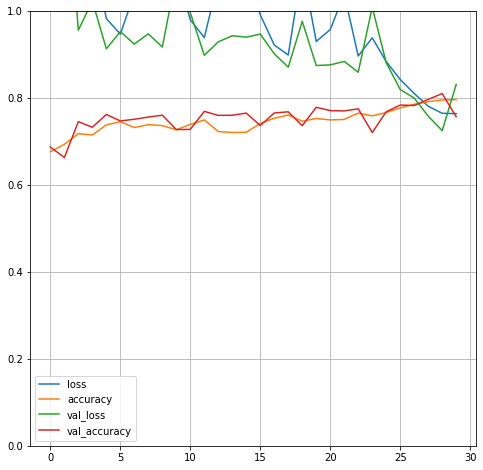

c.shape: (600, 600) x.shape: (1, 600) y.shape: (600, 1)
11250/11250 [==============================] - 50s 4ms/step


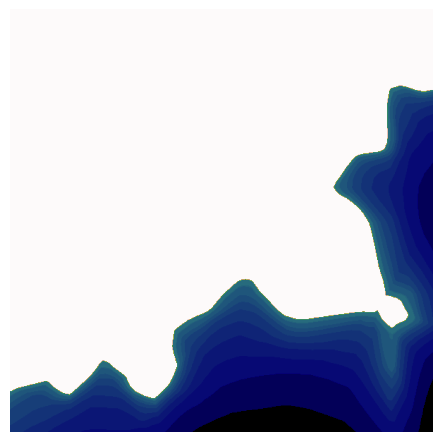

In [21]:
print(trained_model_8[0])
view_history(trained_model_8[1])
view_model_on_image(trained_model_8[2])

model 2 is best!

### Training model 2 from above for longer 150 epochs

In [9]:
hidden_layer_options = [5] 

options_for_number_of_neurons = [500] # Checking this paramter

activation_options = ["relu"]
optimiser_options = ["ADAM"]
num_epochs = [150]
learning_rates = [0.001]

In [10]:
trained_models = train_models(hidden_layer_options, options_for_number_of_neurons, activation_options, optimiser_options, learning_rates, num_epochs, new_X_train, new_Color_train, new_X_test, new_Color_test)

Creating and Trainining 1 Models:
1 / 1 complete
elapsed_time = 2787.929085



In [11]:
trained_model_1 = trained_models[0]

#Hidden layers = 5, #Neurons per hidden layer = 500, Activation = relu, Optimiser = ADAM, Learning Rate = 0.001, #Epochs = 150,


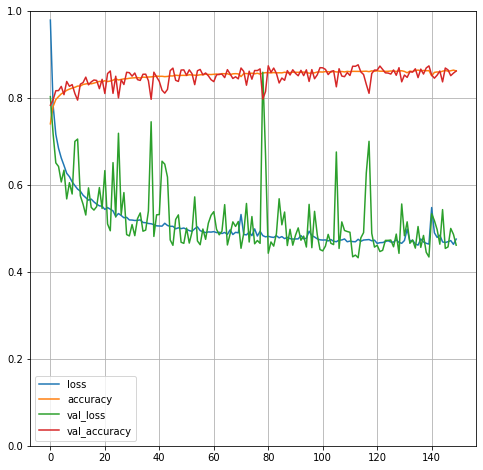

c.shape: (600, 600) x.shape: (1, 600) y.shape: (600, 1)
11250/11250 [==============================] - 12s 1ms/step


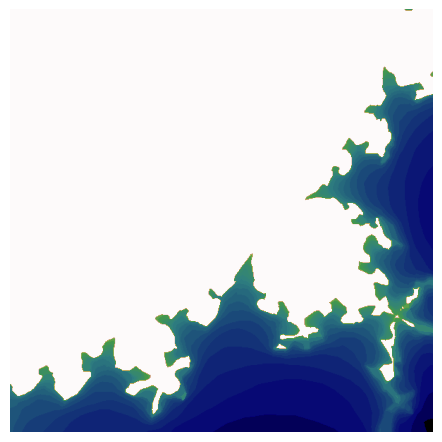

In [12]:
print(trained_model_1[0])
view_history(trained_model_1[1])
view_model_on_image(trained_model_1[2])

In [13]:
hidden_layer_options = [5] 

options_for_number_of_neurons = [500] # Checking this paramter

activation_options = ["relu"]
optimiser_options = ["ADAM"]
num_epochs = [300]
learning_rates = [0.0001]

In [14]:
trained_models = train_models(hidden_layer_options, options_for_number_of_neurons, activation_options, optimiser_options, learning_rates, num_epochs, new_X_train, new_Color_train, new_X_test, new_Color_test)

Creating and Trainining 1 Models:
1 / 1 complete
elapsed_time = 6145.068341



In [15]:
trained_model_1 = trained_models[0]

#Hidden layers = 5, #Neurons per hidden layer = 500, Activation = relu, Optimiser = ADAM, Learning Rate = 0.0001, #Epochs = 300,


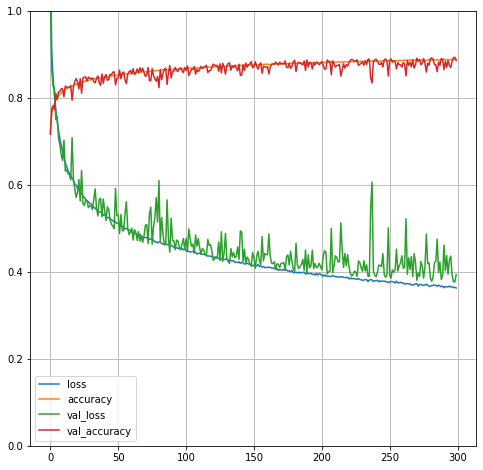

c.shape: (600, 600) x.shape: (1, 600) y.shape: (600, 1)
11250/11250 [==============================] - 13s 1ms/step


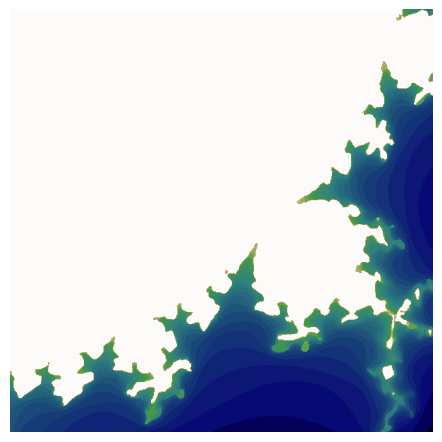

In [16]:
print(trained_model_1[0])
view_history(trained_model_1[1])
view_model_on_image(trained_model_1[2])

In [17]:
hidden_layer_options = [5] 

options_for_number_of_neurons = [500] # Checking this paramter

activation_options = ["relu"]
optimiser_options = ["ADAM"]
num_epochs = [1000]
learning_rates = [0.0001]

In [18]:
def train_models(hidden_layer_options, options_for_number_of_neruons, activation_options, optimiser_options, learning_rates, num_epochs, X_train, Y_train, X_validation, Y_validation):
    num_options = len(hidden_layer_options) * len(options_for_number_of_neruons) * len(activation_options) * len(optimiser_options) * len(learning_rates) * len(num_epochs)
    print("Creating and Trainining {} Models:".format(num_options))
    trained_models = []    
    i = 1
    for hidden_layers in hidden_layer_options:
        for num_neruons in options_for_number_of_neruons:
            for activation in activation_options: 
                for optimiser_to_use in optimiser_options: 
                    for lr in learning_rates:
                        for epochs in num_epochs: 
                            start_time = time.time()
                            if optimiser_to_use == "SGD": 
                                optimiser = tf.keras.optimizers.SGD(learning_rate = lr)
                            
                            elif optimiser_to_use == "ADAM": 
                                optimiser =  tf.keras.optimizers.Adam(learning_rate = lr)
                            
                            elif optimiser_to_use == "RMSprop": 
                                optimiser = tf.keras.optimizers.RMSprop(learning_rate=lr,rho=0.9,momentum=0.0,epsilon=1e-07, centered=False,name='RMSprop')
                            
                            model = get_model(hidden_layers, num_neruons, activation)
                            model.compile(loss = "sparse_categorical_crossentropy", optimizer = optimiser, metrics = ["accuracy"])
                            history = model.fit(X_train, Y_train, epochs = epochs, validation_data = (X_validation, Y_validation), verbose = 1)

                            name = "#Hidden layers = {}, #Neurons per hidden layer = {}, Activation = {}, Optimiser = {}, Learning Rate = {}, #Epochs = {},".format(hidden_layers, num_neruons, activation, optimiser_to_use, lr, epochs)
                            tup = (name, history, model)
                            trained_models.append(tup)
                            end_time = time.time()
                            print("{} / {} complete".format(i, num_options))
                            print("elapsed_time = {:2f}".format(end_time - start_time))
                            print()
                            i += 1
    return trained_models               

In [19]:
trained_models = train_models(hidden_layer_options, options_for_number_of_neurons, activation_options, optimiser_options, learning_rates, num_epochs, new_X_train, new_Color_train, new_X_test, new_Color_test)

Creating and Trainining 1 Models:
Epoch 1/1000
5625/5625 [==============================] - 26s 5ms/step - loss: 1.1554 - accuracy: 0.7182 - val_loss: 0.9629 - val_accuracy: 0.7460
Epoch 2/1000
5625/5625 [==============================] - 25s 4ms/step - loss: 0.9200 - accuracy: 0.7599 - val_loss: 0.8756 - val_accuracy: 0.7771
Epoch 3/1000
5625/5625 [==============================] - 24s 4ms/step - loss: 0.8579 - accuracy: 0.7750 - val_loss: 0.8257 - val_accuracy: 0.7835
Epoch 4/1000
5625/5625 [==============================] - 24s 4ms/step - loss: 0.8130 - accuracy: 0.7855 - val_loss: 0.7837 - val_accuracy: 0.8013
Epoch 5/1000
5625/5625 [==============================] - 24s 4ms/step - loss: 0.7811 - accuracy: 0.7921 - val_loss: 0.7456 - val_accuracy: 0.8066
Epoch 6/1000
5625/5625 [==============================] - 23s 4ms/step - loss: 0.7534 - accuracy: 0.7989 - val_loss: 0.7605 - val_accuracy: 0.7948
Epoch 7/1000
5625/5625 [==============================] - 23s 4ms/step - loss: 0.732

5625/5625 [==============================] - 22s 4ms/step - loss: 0.4445 - accuracy: 0.8690 - val_loss: 0.4821 - val_accuracy: 0.8583
Epoch 112/1000
5625/5625 [==============================] - 22s 4ms/step - loss: 0.4407 - accuracy: 0.8698 - val_loss: 0.4299 - val_accuracy: 0.8774
Epoch 113/1000
5625/5625 [==============================] - 22s 4ms/step - loss: 0.4420 - accuracy: 0.8695 - val_loss: 0.4568 - val_accuracy: 0.8678
Epoch 114/1000
5625/5625 [==============================] - 22s 4ms/step - loss: 0.4416 - accuracy: 0.8694 - val_loss: 0.4352 - val_accuracy: 0.8759
Epoch 115/1000
5625/5625 [==============================] - 22s 4ms/step - loss: 0.4400 - accuracy: 0.8702 - val_loss: 0.4527 - val_accuracy: 0.8666
Epoch 116/1000
5625/5625 [==============================] - 23s 4ms/step - loss: 0.4405 - accuracy: 0.8701 - val_loss: 0.4661 - val_accuracy: 0.8643
Epoch 117/1000
5625/5625 [==============================] - 23s 4ms/step - loss: 0.4362 - accuracy: 0.8714 - val_loss: 0.

5625/5625 [==============================] - 22s 4ms/step - loss: 0.4094 - accuracy: 0.8771 - val_loss: 0.4109 - val_accuracy: 0.8827
Epoch 167/1000
5625/5625 [==============================] - 23s 4ms/step - loss: 0.4088 - accuracy: 0.8774 - val_loss: 0.4336 - val_accuracy: 0.8726
Epoch 168/1000
5625/5625 [==============================] - 23s 4ms/step - loss: 0.4102 - accuracy: 0.8772 - val_loss: 0.4156 - val_accuracy: 0.8820
Epoch 169/1000
5625/5625 [==============================] - 23s 4ms/step - loss: 0.4070 - accuracy: 0.8777 - val_loss: 0.4146 - val_accuracy: 0.8817
Epoch 170/1000
5625/5625 [==============================] - 23s 4ms/step - loss: 0.4063 - accuracy: 0.8780 - val_loss: 0.4296 - val_accuracy: 0.8736
Epoch 171/1000
5625/5625 [==============================] - 23s 4ms/step - loss: 0.4069 - accuracy: 0.8777 - val_loss: 0.4098 - val_accuracy: 0.8821
Epoch 172/1000
5625/5625 [==============================] - 23s 4ms/step - loss: 0.4043 - accuracy: 0.8787 - val_loss: 0.

5625/5625 [==============================] - 23s 4ms/step - loss: 0.3874 - accuracy: 0.8825 - val_loss: 0.4151 - val_accuracy: 0.8800
Epoch 222/1000
5625/5625 [==============================] - 23s 4ms/step - loss: 0.3867 - accuracy: 0.8830 - val_loss: 0.3945 - val_accuracy: 0.8891
Epoch 223/1000
5625/5625 [==============================] - 23s 4ms/step - loss: 0.3858 - accuracy: 0.8832 - val_loss: 0.4194 - val_accuracy: 0.8770
Epoch 224/1000
5625/5625 [==============================] - 23s 4ms/step - loss: 0.3862 - accuracy: 0.8831 - val_loss: 0.4004 - val_accuracy: 0.8873
Epoch 225/1000
5625/5625 [==============================] - 24s 4ms/step - loss: 0.3867 - accuracy: 0.8831 - val_loss: 0.4122 - val_accuracy: 0.8814
Epoch 226/1000
5625/5625 [==============================] - 24s 4ms/step - loss: 0.3854 - accuracy: 0.8831 - val_loss: 0.4190 - val_accuracy: 0.8796
Epoch 227/1000
5625/5625 [==============================] - 23s 4ms/step - loss: 0.3856 - accuracy: 0.8837 - val_loss: 0.

5625/5625 [==============================] - 25s 4ms/step - loss: 0.3714 - accuracy: 0.8876 - val_loss: 0.4085 - val_accuracy: 0.8818
Epoch 277/1000
5625/5625 [==============================] - 26s 5ms/step - loss: 0.3690 - accuracy: 0.8874 - val_loss: 0.4159 - val_accuracy: 0.8782
Epoch 278/1000
5625/5625 [==============================] - 25s 4ms/step - loss: 0.3701 - accuracy: 0.8877 - val_loss: 0.4161 - val_accuracy: 0.8781
Epoch 279/1000
5625/5625 [==============================] - 26s 5ms/step - loss: 0.3703 - accuracy: 0.8867 - val_loss: 0.4115 - val_accuracy: 0.8813
Epoch 280/1000
5625/5625 [==============================] - 25s 4ms/step - loss: 0.3699 - accuracy: 0.8873 - val_loss: 0.4019 - val_accuracy: 0.8827
Epoch 281/1000
5625/5625 [==============================] - 25s 4ms/step - loss: 0.3669 - accuracy: 0.8881 - val_loss: 0.4503 - val_accuracy: 0.8733
Epoch 282/1000
5625/5625 [==============================] - 25s 4ms/step - loss: 0.3695 - accuracy: 0.8878 - val_loss: 0.

5625/5625 [==============================] - 26s 5ms/step - loss: 0.3577 - accuracy: 0.8900 - val_loss: 0.4481 - val_accuracy: 0.8763
Epoch 332/1000
5625/5625 [==============================] - 25s 4ms/step - loss: 0.3571 - accuracy: 0.8902 - val_loss: 0.3746 - val_accuracy: 0.8950
Epoch 333/1000
5625/5625 [==============================] - 25s 5ms/step - loss: 0.3572 - accuracy: 0.8903 - val_loss: 0.3865 - val_accuracy: 0.8909
Epoch 334/1000
5625/5625 [==============================] - 25s 5ms/step - loss: 0.3556 - accuracy: 0.8905 - val_loss: 0.3780 - val_accuracy: 0.8913
Epoch 335/1000
5625/5625 [==============================] - 26s 5ms/step - loss: 0.3583 - accuracy: 0.8901 - val_loss: 0.3935 - val_accuracy: 0.8871
Epoch 336/1000
5625/5625 [==============================] - 25s 4ms/step - loss: 0.3576 - accuracy: 0.8905 - val_loss: 0.4013 - val_accuracy: 0.8813
Epoch 337/1000
5625/5625 [==============================] - 26s 5ms/step - loss: 0.3569 - accuracy: 0.8900 - val_loss: 0.

5625/5625 [==============================] - 27s 5ms/step - loss: 0.3490 - accuracy: 0.8923 - val_loss: 0.4009 - val_accuracy: 0.8838
Epoch 387/1000
5625/5625 [==============================] - 28s 5ms/step - loss: 0.3481 - accuracy: 0.8920 - val_loss: 0.3790 - val_accuracy: 0.8918
Epoch 388/1000
5625/5625 [==============================] - 27s 5ms/step - loss: 0.3473 - accuracy: 0.8928 - val_loss: 0.3920 - val_accuracy: 0.8864
Epoch 389/1000
5625/5625 [==============================] - 28s 5ms/step - loss: 0.3465 - accuracy: 0.8933 - val_loss: 0.3863 - val_accuracy: 0.8889
Epoch 390/1000
5625/5625 [==============================] - 27s 5ms/step - loss: 0.3498 - accuracy: 0.8916 - val_loss: 0.3795 - val_accuracy: 0.8960
Epoch 391/1000
5625/5625 [==============================] - 27s 5ms/step - loss: 0.3472 - accuracy: 0.8925 - val_loss: 0.3803 - val_accuracy: 0.8908
Epoch 392/1000
5625/5625 [==============================] - 27s 5ms/step - loss: 0.3450 - accuracy: 0.8935 - val_loss: 0.

5625/5625 [==============================] - 28s 5ms/step - loss: 0.3408 - accuracy: 0.8943 - val_loss: 0.3764 - val_accuracy: 0.8921
Epoch 442/1000
5625/5625 [==============================] - 29s 5ms/step - loss: 0.3411 - accuracy: 0.8946 - val_loss: 0.4004 - val_accuracy: 0.8891
Epoch 443/1000
5625/5625 [==============================] - 28s 5ms/step - loss: 0.3403 - accuracy: 0.8941 - val_loss: 0.3733 - val_accuracy: 0.8947
Epoch 444/1000
5625/5625 [==============================] - 29s 5ms/step - loss: 0.3392 - accuracy: 0.8945 - val_loss: 0.3728 - val_accuracy: 0.8951
Epoch 445/1000
5625/5625 [==============================] - 28s 5ms/step - loss: 0.3415 - accuracy: 0.8943 - val_loss: 0.3798 - val_accuracy: 0.8905
Epoch 446/1000
5625/5625 [==============================] - 28s 5ms/step - loss: 0.3373 - accuracy: 0.8954 - val_loss: 0.3844 - val_accuracy: 0.8887
Epoch 447/1000
5625/5625 [==============================] - 30s 5ms/step - loss: 0.3388 - accuracy: 0.8950 - val_loss: 0.

5625/5625 [==============================] - 30s 5ms/step - loss: 0.3333 - accuracy: 0.8957 - val_loss: 0.3771 - val_accuracy: 0.8943
Epoch 497/1000
5625/5625 [==============================] - 29s 5ms/step - loss: 0.3330 - accuracy: 0.8963 - val_loss: 0.3886 - val_accuracy: 0.8903
Epoch 498/1000
5625/5625 [==============================] - 29s 5ms/step - loss: 0.3328 - accuracy: 0.8963 - val_loss: 0.4226 - val_accuracy: 0.8779
Epoch 499/1000
5625/5625 [==============================] - 29s 5ms/step - loss: 0.3345 - accuracy: 0.8957 - val_loss: 0.4056 - val_accuracy: 0.8819
Epoch 500/1000
5625/5625 [==============================] - 30s 5ms/step - loss: 0.3314 - accuracy: 0.8963 - val_loss: 0.3685 - val_accuracy: 0.8953
Epoch 501/1000
5625/5625 [==============================] - 29s 5ms/step - loss: 0.3337 - accuracy: 0.8958 - val_loss: 0.4082 - val_accuracy: 0.8871
Epoch 502/1000
5625/5625 [==============================] - 29s 5ms/step - loss: 0.3325 - accuracy: 0.8959 - val_loss: 0.

5625/5625 [==============================] - 31s 5ms/step - loss: 0.3266 - accuracy: 0.8980 - val_loss: 0.3607 - val_accuracy: 0.8991
Epoch 552/1000
5625/5625 [==============================] - 30s 5ms/step - loss: 0.3253 - accuracy: 0.8984 - val_loss: 0.3950 - val_accuracy: 0.8885
Epoch 553/1000
5625/5625 [==============================] - 32s 6ms/step - loss: 0.3290 - accuracy: 0.8975 - val_loss: 0.3767 - val_accuracy: 0.8927
Epoch 554/1000
5625/5625 [==============================] - 30s 5ms/step - loss: 0.3277 - accuracy: 0.8977 - val_loss: 0.4420 - val_accuracy: 0.8742
Epoch 555/1000
5625/5625 [==============================] - 31s 6ms/step - loss: 0.3284 - accuracy: 0.8967 - val_loss: 0.3927 - val_accuracy: 0.8865
Epoch 556/1000
5625/5625 [==============================] - 31s 5ms/step - loss: 0.3268 - accuracy: 0.8977 - val_loss: 0.3843 - val_accuracy: 0.8923
Epoch 557/1000
5625/5625 [==============================] - 30s 5ms/step - loss: 0.3240 - accuracy: 0.8982 - val_loss: 0.

5625/5625 [==============================] - 32s 6ms/step - loss: 0.3208 - accuracy: 0.8992 - val_loss: 0.3816 - val_accuracy: 0.8921
Epoch 607/1000
5625/5625 [==============================] - 31s 5ms/step - loss: 0.3235 - accuracy: 0.8988 - val_loss: 0.3924 - val_accuracy: 0.8856
Epoch 608/1000
5625/5625 [==============================] - 31s 6ms/step - loss: 0.3197 - accuracy: 0.8994 - val_loss: 0.3865 - val_accuracy: 0.8908
Epoch 609/1000
5625/5625 [==============================] - 31s 6ms/step - loss: 0.3221 - accuracy: 0.8990 - val_loss: 0.3914 - val_accuracy: 0.8890
Epoch 610/1000
5625/5625 [==============================] - 31s 6ms/step - loss: 0.3215 - accuracy: 0.8991 - val_loss: 0.4172 - val_accuracy: 0.8811
Epoch 611/1000
5625/5625 [==============================] - 32s 6ms/step - loss: 0.3203 - accuracy: 0.8990 - val_loss: 0.3711 - val_accuracy: 0.8957
Epoch 612/1000
5625/5625 [==============================] - 31s 6ms/step - loss: 0.3180 - accuracy: 0.8999 - val_loss: 0.

5625/5625 [==============================] - 32s 6ms/step - loss: 0.3202 - accuracy: 0.8984 - val_loss: 0.3801 - val_accuracy: 0.8925
Epoch 662/1000
5625/5625 [==============================] - 34s 6ms/step - loss: 0.3166 - accuracy: 0.8998 - val_loss: 0.3785 - val_accuracy: 0.8961
Epoch 663/1000
5625/5625 [==============================] - 32s 6ms/step - loss: 0.3167 - accuracy: 0.9002 - val_loss: 0.3949 - val_accuracy: 0.8877
Epoch 664/1000
5625/5625 [==============================] - 32s 6ms/step - loss: 0.3156 - accuracy: 0.8994 - val_loss: 0.4156 - val_accuracy: 0.8841
Epoch 665/1000
5625/5625 [==============================] - 32s 6ms/step - loss: 0.3181 - accuracy: 0.8991 - val_loss: 0.3845 - val_accuracy: 0.8908
Epoch 666/1000
5625/5625 [==============================] - 32s 6ms/step - loss: 0.3180 - accuracy: 0.8997 - val_loss: 0.4164 - val_accuracy: 0.8837
Epoch 667/1000
5625/5625 [==============================] - 32s 6ms/step - loss: 0.3173 - accuracy: 0.9001 - val_loss: 0.

5625/5625 [==============================] - 34s 6ms/step - loss: 0.3143 - accuracy: 0.9000 - val_loss: 0.3763 - val_accuracy: 0.8965
Epoch 717/1000
5625/5625 [==============================] - 34s 6ms/step - loss: 0.3150 - accuracy: 0.9004 - val_loss: 0.4034 - val_accuracy: 0.8843
Epoch 718/1000
5625/5625 [==============================] - 33s 6ms/step - loss: 0.3111 - accuracy: 0.9011 - val_loss: 0.3859 - val_accuracy: 0.8933
Epoch 719/1000
5625/5625 [==============================] - 34s 6ms/step - loss: 0.3125 - accuracy: 0.9008 - val_loss: 0.3606 - val_accuracy: 0.8991
Epoch 720/1000
5625/5625 [==============================] - 33s 6ms/step - loss: 0.3171 - accuracy: 0.9005 - val_loss: 0.3647 - val_accuracy: 0.9003
Epoch 721/1000
5625/5625 [==============================] - 34s 6ms/step - loss: 0.3147 - accuracy: 0.9002 - val_loss: 0.3930 - val_accuracy: 0.8897
Epoch 722/1000
5625/5625 [==============================] - 34s 6ms/step - loss: 0.3121 - accuracy: 0.9008 - val_loss: 0.

5625/5625 [==============================] - 35s 6ms/step - loss: 0.3084 - accuracy: 0.9017 - val_loss: 0.4104 - val_accuracy: 0.8864
Epoch 772/1000
5625/5625 [==============================] - 36s 6ms/step - loss: 0.3112 - accuracy: 0.9010 - val_loss: 0.3830 - val_accuracy: 0.8948
Epoch 773/1000
5625/5625 [==============================] - 36s 6ms/step - loss: 0.3099 - accuracy: 0.9011 - val_loss: 0.3774 - val_accuracy: 0.8954
Epoch 774/1000
5625/5625 [==============================] - 35s 6ms/step - loss: 0.3096 - accuracy: 0.9020 - val_loss: 0.3825 - val_accuracy: 0.8921
Epoch 775/1000
5625/5625 [==============================] - 35s 6ms/step - loss: 0.3105 - accuracy: 0.9014 - val_loss: 0.3690 - val_accuracy: 0.8991
Epoch 776/1000
5625/5625 [==============================] - 35s 6ms/step - loss: 0.3113 - accuracy: 0.9011 - val_loss: 0.3792 - val_accuracy: 0.8940
Epoch 777/1000
5625/5625 [==============================] - 36s 6ms/step - loss: 0.3104 - accuracy: 0.9016 - val_loss: 0.

5625/5625 [==============================] - 37s 7ms/step - loss: 0.3039 - accuracy: 0.9037 - val_loss: 0.3744 - val_accuracy: 0.8964
Epoch 827/1000
5625/5625 [==============================] - 36s 6ms/step - loss: 0.3090 - accuracy: 0.9026 - val_loss: 0.3754 - val_accuracy: 0.8957
Epoch 828/1000
5625/5625 [==============================] - 37s 7ms/step - loss: 0.3043 - accuracy: 0.9029 - val_loss: 0.4092 - val_accuracy: 0.8864
Epoch 829/1000
5625/5625 [==============================] - 36s 6ms/step - loss: 0.3057 - accuracy: 0.9022 - val_loss: 0.3719 - val_accuracy: 0.8967
Epoch 830/1000
5625/5625 [==============================] - 37s 7ms/step - loss: 0.3052 - accuracy: 0.9027 - val_loss: 0.4965 - val_accuracy: 0.8665
Epoch 831/1000
5625/5625 [==============================] - 36s 6ms/step - loss: 0.3069 - accuracy: 0.9022 - val_loss: 0.3964 - val_accuracy: 0.8902
Epoch 832/1000
5625/5625 [==============================] - 36s 6ms/step - loss: 0.3078 - accuracy: 0.9016 - val_loss: 0.

5625/5625 [==============================] - 39s 7ms/step - loss: 0.3034 - accuracy: 0.9031 - val_loss: 0.3615 - val_accuracy: 0.9002
Epoch 882/1000
5625/5625 [==============================] - 38s 7ms/step - loss: 0.3041 - accuracy: 0.9032 - val_loss: 0.3575 - val_accuracy: 0.9029
Epoch 883/1000
5625/5625 [==============================] - 39s 7ms/step - loss: 0.3063 - accuracy: 0.9024 - val_loss: 0.3817 - val_accuracy: 0.8939
Epoch 884/1000
5625/5625 [==============================] - 39s 7ms/step - loss: 0.3069 - accuracy: 0.9022 - val_loss: 0.3915 - val_accuracy: 0.8926
Epoch 885/1000
5625/5625 [==============================] - 38s 7ms/step - loss: 0.3064 - accuracy: 0.9021 - val_loss: 0.4288 - val_accuracy: 0.8829
Epoch 886/1000
5625/5625 [==============================] - 41s 7ms/step - loss: 0.3042 - accuracy: 0.9031 - val_loss: 0.3891 - val_accuracy: 0.8913
Epoch 887/1000
5625/5625 [==============================] - 38s 7ms/step - loss: 0.3026 - accuracy: 0.9033 - val_loss: 0.

5625/5625 [==============================] - 47s 8ms/step - loss: 0.3009 - accuracy: 0.9033 - val_loss: 0.3757 - val_accuracy: 0.8961
Epoch 937/1000
5625/5625 [==============================] - 47s 8ms/step - loss: 0.3035 - accuracy: 0.9033 - val_loss: 0.3907 - val_accuracy: 0.8928
Epoch 938/1000
5625/5625 [==============================] - 47s 8ms/step - loss: 0.3008 - accuracy: 0.9035 - val_loss: 0.3855 - val_accuracy: 0.8968
Epoch 939/1000
5625/5625 [==============================] - 47s 8ms/step - loss: 0.3025 - accuracy: 0.9033 - val_loss: 0.3878 - val_accuracy: 0.8945
Epoch 940/1000
5625/5625 [==============================] - 48s 8ms/step - loss: 0.3003 - accuracy: 0.9035 - val_loss: 0.3740 - val_accuracy: 0.8984
Epoch 941/1000
5625/5625 [==============================] - 47s 8ms/step - loss: 0.3007 - accuracy: 0.9040 - val_loss: 0.3880 - val_accuracy: 0.8922
Epoch 942/1000
5625/5625 [==============================] - 47s 8ms/step - loss: 0.3010 - accuracy: 0.9040 - val_loss: 0.

5625/5625 [==============================] - 49s 9ms/step - loss: 0.2995 - accuracy: 0.9036 - val_loss: 0.3808 - val_accuracy: 0.8963
Epoch 992/1000
5625/5625 [==============================] - 49s 9ms/step - loss: 0.2980 - accuracy: 0.9047 - val_loss: 0.3863 - val_accuracy: 0.8979
Epoch 993/1000
5625/5625 [==============================] - 49s 9ms/step - loss: 0.2977 - accuracy: 0.9047 - val_loss: 0.4006 - val_accuracy: 0.8904
Epoch 994/1000
5625/5625 [==============================] - 53s 9ms/step - loss: 0.2984 - accuracy: 0.9039 - val_loss: 0.3873 - val_accuracy: 0.8936
Epoch 995/1000
5625/5625 [==============================] - 50s 9ms/step - loss: 0.3004 - accuracy: 0.9042 - val_loss: 0.3841 - val_accuracy: 0.8962
Epoch 996/1000
5625/5625 [==============================] - 50s 9ms/step - loss: 0.2970 - accuracy: 0.9046 - val_loss: 0.4250 - val_accuracy: 0.8835
Epoch 997/1000
5625/5625 [==============================] - 49s 9ms/step - loss: 0.2992 - accuracy: 0.9038 - val_loss: 0.

In [20]:
trained_model_1 = trained_models[0]

#Hidden layers = 5, #Neurons per hidden layer = 500, Activation = relu, Optimiser = ADAM, Learning Rate = 0.0001, #Epochs = 1000,


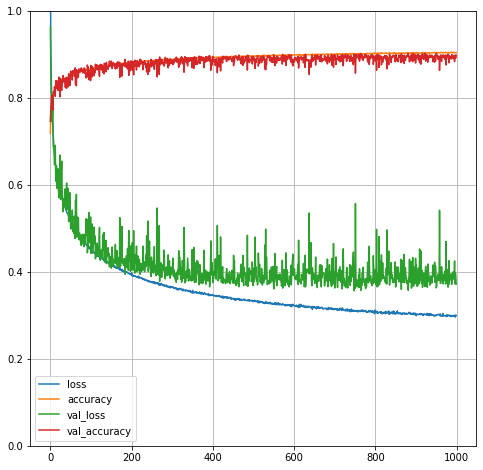

c.shape: (600, 600) x.shape: (1, 600) y.shape: (600, 1)
11250/11250 [==============================] - 26s 2ms/step


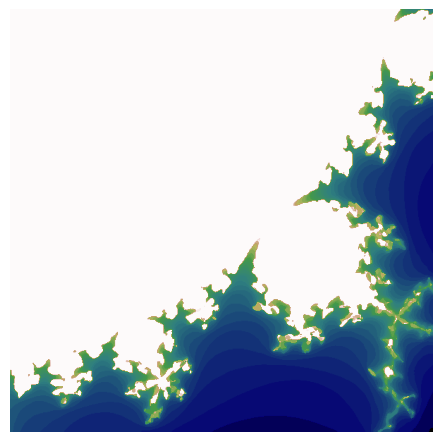

In [21]:
print(trained_model_1[0])
view_history(trained_model_1[1])
view_model_on_image(trained_model_1[2])